In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/nyoman.setiawan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 63


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(301040, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,630206106C2#01,630206106C2,630206106,1,2022_03,2,V2,50MLB,-15.316709,-13.603502,...,-24.917480,-22.014889,-23.470753,-20.384851,-19.337974,6302,1,0.785793,R19C1,0.394366
1,630206106C2#02,630206106C2,630206106,1,2022_03,2,V2,50MLB,-16.280683,-13.633815,...,-23.761356,-21.570981,-23.477442,-20.949137,-19.259468,6302,1,0.785793,R13C3,0.705263
2,630206106C2#03,630206106C2,630206106,1,2022_03,2,V2,50MLB,-15.388859,-12.940852,...,-25.063286,-21.629247,-23.278772,-19.694874,-18.537942,6302,1,0.785793,R13C3,0.705263
3,630206106C2#04,630206106C2,630206106,1,2022_03,2,V2,50MLB,-16.514003,-14.818329,...,-21.829735,-21.375439,-24.610804,-20.746988,-20.439097,6302,1,0.785793,R19C1,0.394366
4,630206106C2#05,630206106C2,630206106,1,2022_03,2,V2,50MLB,-17.165164,-18.505693,...,-22.820148,-20.985597,-23.720848,-19.737125,-19.213659,6302,1,0.785793,R19C1,0.394366


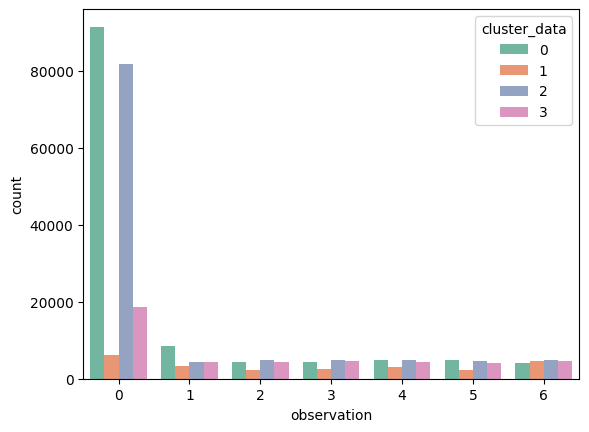

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-23 07:51:14,466] A new study created in memory with name: no-name-d21e1e99-b2a7-4542-b3ce-bf1bdec18802


[4 5 0 6 1 2 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 07:52:13,515] Trial 0 finished with value: 0.7741023768969493 and parameters: {'max_depth': 7, 'learning_rate': 0.04018757782486618, 'reg_lambda': 4.394287252369526, 'min_child_weight': 86}. Best is trial 0 with value: 0.7741023768969493.
[I 2024-10-23 07:52:45,466] Trial 1 finished with value: 0.7779039747636284 and parameters: {'max_depth': 7, 'learning_rate': 0.09496917949902374, 'reg_lambda': 2.906448283676849, 'min_child_weight': 50}. Best is trial 1 with value: 0.7779039747636284.
[I 2024-10-23 07:53:40,012] Trial 2 finished with value: 0.7547766086768317 and parameters: {'max_depth': 6, 'learning_rate': 0.024300403516824803, 'reg_lambda': 2.7650630067730293, 'min_child_weight': 88}. Best is trial 1 with value: 0.7779039747636284.
[I 2024-10-23 07:54:20,971] Trial 3 finished with value: 0.7776229177905835 and parameters: {'max_depth': 6, 'learning_rate': 0.08948172200547222, 'reg_lambda': 2.772344687333261, 'min_child_weight': 55}. Best is trial 1 with value: 0.7779

Best Parameters: {'max_depth': 8, 'learning_rate': 0.06832938266810734, 'reg_lambda': 0.41810513882036693, 'min_child_weight': 50}
Best Score: 0.7801901081572512
Start the modelling
[0]	train-mlogloss:1.78460	eval-mlogloss:1.81267
[100]	train-mlogloss:0.15242	eval-mlogloss:0.41601
[200]	train-mlogloss:0.07066	eval-mlogloss:0.33381
[300]	train-mlogloss:0.04179	eval-mlogloss:0.30155
[400]	train-mlogloss:0.02868	eval-mlogloss:0.28853
[500]	train-mlogloss:0.02172	eval-mlogloss:0.28458
[600]	train-mlogloss:0.01718	eval-mlogloss:0.28370
[700]	train-mlogloss:0.01380	eval-mlogloss:0.28435
[800]	train-mlogloss:0.01172	eval-mlogloss:0.28625
[900]	train-mlogloss:0.01010	eval-mlogloss:0.28820
[1000]	train-mlogloss:0.00890	eval-mlogloss:0.29059
[1100]	train-mlogloss:0.00790	eval-mlogloss:0.29258
[1200]	train-mlogloss:0.00712	eval-mlogloss:0.29512
[1300]	train-mlogloss:0.00651	eval-mlogloss:0.29747
[1400]	train-mlogloss:0.00600	eval-mlogloss:0.29984
[1500]	train-mlogloss:0.00557	eval-mlogloss:0.3020

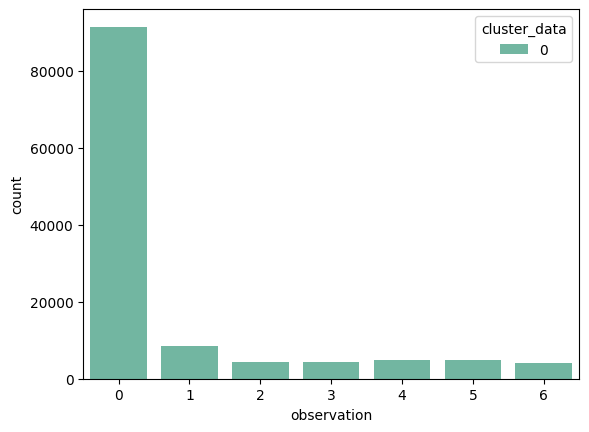

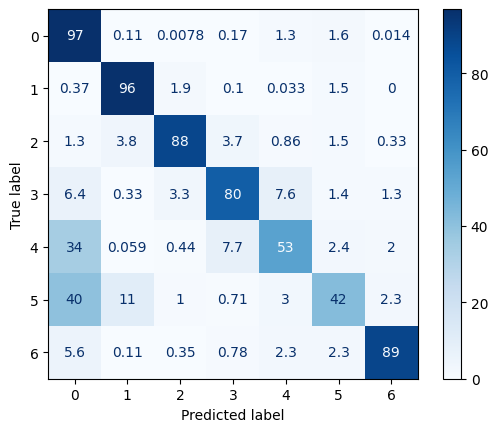

{'average_accuracy': 0.9176506150137224, 'average_f1_macro': 0.7813485488689325, 'average_f1_micro': 0.9176506150137224, 'average_auc': 0.9647710238628456, 'average_acc_kelas_generatif': 0.8164362519201229, 'average_acc_fase_padi': 0.812906392411163}
{'val_accuracy': 0.9174505977352669, 'val_f1_macro': 0.7900797539789702, 'val_f1_micro': 0.9174505977352669, 'val_auc': 0.9669434638681798, 'val_acc_kelas_generatif': 0.7971682581494897, 'val_acc_fase_padi': 0.8203713321215269, 'val_relative_acc': 98.71065604854}
CLUSTER:  1


[I 2024-10-23 08:09:06,948] A new study created in memory with name: no-name-b79408f5-8a49-4dcb-bde7-0f59634393c1


[2 6 1 4 0 5 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 08:09:29,827] Trial 0 finished with value: 0.6270050745936476 and parameters: {'max_depth': 7, 'learning_rate': 0.039635048263133556, 'reg_lambda': 3.3066074341970455, 'min_child_weight': 84}. Best is trial 0 with value: 0.6270050745936476.
[I 2024-10-23 08:09:45,374] Trial 1 finished with value: 0.6340295919222365 and parameters: {'max_depth': 10, 'learning_rate': 0.05740240747837062, 'reg_lambda': 3.3340184922485374, 'min_child_weight': 60}. Best is trial 1 with value: 0.6340295919222365.
[I 2024-10-23 08:09:57,940] Trial 2 finished with value: 0.6282412792139337 and parameters: {'max_depth': 9, 'learning_rate': 0.0764251062017709, 'reg_lambda': 2.25843694820332, 'min_child_weight': 66}. Best is trial 1 with value: 0.6340295919222365.
[I 2024-10-23 08:10:11,341] Trial 3 finished with value: 0.6248767892088963 and parameters: {'max_depth': 8, 'learning_rate': 0.0685829911362885, 'reg_lambda': 3.620977110099668, 'min_child_weight': 72}. Best is trial 1 with value: 0.63402

Best Parameters: {'max_depth': 10, 'learning_rate': 0.05740240747837062, 'reg_lambda': 3.3340184922485374, 'min_child_weight': 60}
Best Score: 0.6340295919222365
Start the modelling
[0]	train-mlogloss:1.86736	eval-mlogloss:1.88631
[100]	train-mlogloss:0.33576	eval-mlogloss:0.97991
[200]	train-mlogloss:0.16886	eval-mlogloss:0.94303
[300]	train-mlogloss:0.10559	eval-mlogloss:0.94425
[400]	train-mlogloss:0.07506	eval-mlogloss:0.95482
[500]	train-mlogloss:0.05859	eval-mlogloss:0.96858
[600]	train-mlogloss:0.04851	eval-mlogloss:0.98091
[700]	train-mlogloss:0.04187	eval-mlogloss:0.99147
[800]	train-mlogloss:0.03723	eval-mlogloss:1.00103
[900]	train-mlogloss:0.03380	eval-mlogloss:1.00788
[1000]	train-mlogloss:0.03115	eval-mlogloss:1.01448
[1100]	train-mlogloss:0.02902	eval-mlogloss:1.02136
[1200]	train-mlogloss:0.02727	eval-mlogloss:1.02911
[1244]	train-mlogloss:0.02662	eval-mlogloss:1.03188
[0]	train-mlogloss:1.86779	eval-mlogloss:1.88509
[100]	train-mlogloss:0.33198	eval-mlogloss:0.92582
[2

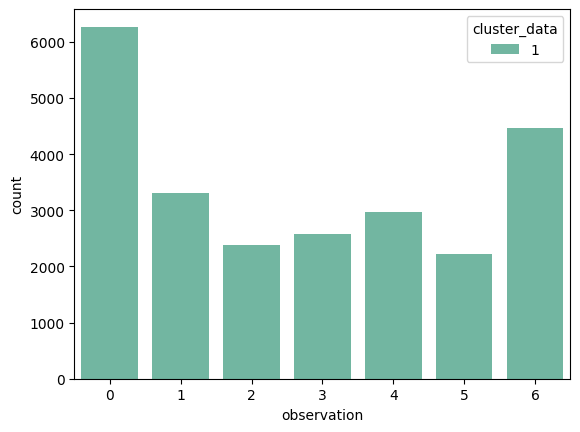

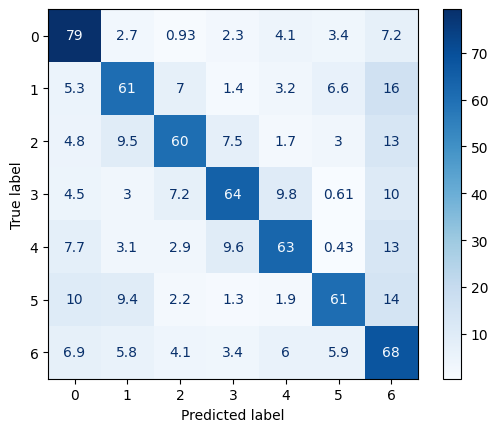

{'average_accuracy': 0.6555535436290069, 'average_f1_macro': 0.6349620344956566, 'average_f1_micro': 0.6555535436290069, 'average_auc': 0.9214030020513791, 'average_acc_kelas_generatif': 0.5750912436280277, 'average_acc_fase_padi': 0.6014209456145447}
{'val_accuracy': 0.6747165800661313, 'val_f1_macro': 0.6559633778347377, 'val_f1_micro': 0.6747165800661313, 'val_auc': 0.9340292075912592, 'val_acc_kelas_generatif': 0.6439267886855241, 'val_acc_fase_padi': 0.6205141257317384, 'val_relative_acc': 94.2963257726489}
CLUSTER:  2


[I 2024-10-23 08:17:05,056] A new study created in memory with name: no-name-2c86f764-a96a-40c6-bd8d-66fca6ca99dd


[6 1 4 0 5 2 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 08:18:34,451] Trial 0 finished with value: 0.5066301997057358 and parameters: {'max_depth': 10, 'learning_rate': 0.026237629630359527, 'reg_lambda': 1.5365117478470878, 'min_child_weight': 95}. Best is trial 0 with value: 0.5066301997057358.
[I 2024-10-23 08:19:35,741] Trial 1 finished with value: 0.4896579459941148 and parameters: {'max_depth': 6, 'learning_rate': 0.02105979687887255, 'reg_lambda': 4.792768514305902, 'min_child_weight': 60}. Best is trial 0 with value: 0.5066301997057358.
[I 2024-10-23 08:20:21,508] Trial 2 finished with value: 0.5090034332734251 and parameters: {'max_depth': 10, 'learning_rate': 0.06890110529167555, 'reg_lambda': 0.14705713998747919, 'min_child_weight': 77}. Best is trial 2 with value: 0.5090034332734251.
[I 2024-10-23 08:21:12,278] Trial 3 finished with value: 0.5020714425334326 and parameters: {'max_depth': 6, 'learning_rate': 0.08404309873753403, 'reg_lambda': 2.010168808462344, 'min_child_weight': 87}. Best is trial 2 with value: 0.

Best Parameters: {'max_depth': 10, 'learning_rate': 0.0987540291889882, 'reg_lambda': 3.2492799560628174, 'min_child_weight': 57}
Best Score: 0.514721866810682
Start the modelling
[0]	train-mlogloss:1.79314	eval-mlogloss:1.81483
[100]	train-mlogloss:0.15177	eval-mlogloss:0.64212
[200]	train-mlogloss:0.06675	eval-mlogloss:0.59230
[300]	train-mlogloss:0.04089	eval-mlogloss:0.58767
[400]	train-mlogloss:0.02856	eval-mlogloss:0.59360
[500]	train-mlogloss:0.02189	eval-mlogloss:0.60210
[600]	train-mlogloss:0.01766	eval-mlogloss:0.61082
[700]	train-mlogloss:0.01472	eval-mlogloss:0.61967
[800]	train-mlogloss:0.01269	eval-mlogloss:0.62748
[900]	train-mlogloss:0.01127	eval-mlogloss:0.63463
[1000]	train-mlogloss:0.01015	eval-mlogloss:0.64129
[1100]	train-mlogloss:0.00922	eval-mlogloss:0.64800
[1200]	train-mlogloss:0.00850	eval-mlogloss:0.65309
[1281]	train-mlogloss:0.00802	eval-mlogloss:0.65731
[0]	train-mlogloss:1.79006	eval-mlogloss:1.81196
[100]	train-mlogloss:0.15531	eval-mlogloss:0.66375
[200

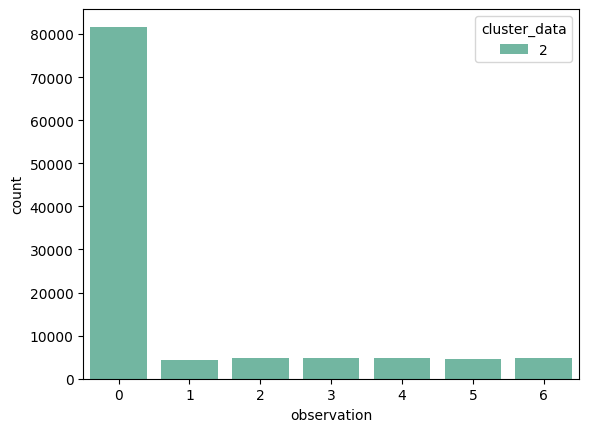

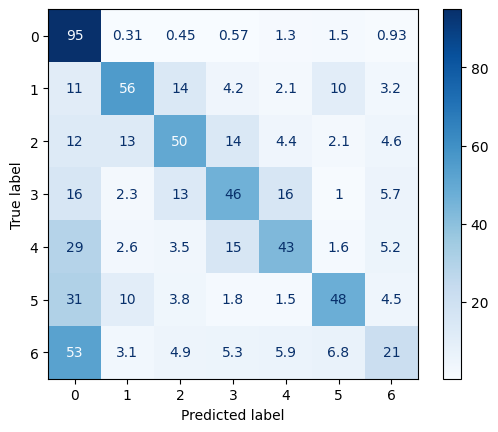

{'average_accuracy': 0.8193605637682092, 'average_f1_macro': 0.5104049380089327, 'average_f1_micro': 0.8193605637682092, 'average_auc': 0.9103392816495973, 'average_acc_kelas_generatif': 0.46403872752420466, 'average_acc_fase_padi': 0.4745168242675075}
{'val_accuracy': 0.8184941311193816, 'val_f1_macro': 0.5262183569020548, 'val_f1_micro': 0.8184941311193816, 'val_auc': 0.9161446878069094, 'val_acc_kelas_generatif': 0.46443390634262005, 'val_acc_fase_padi': 0.48570333461096205, 'val_relative_acc': 92.69580760480989}
CLUSTER:  3


[I 2024-10-23 08:35:06,402] A new study created in memory with name: no-name-b7637974-b1b6-4dff-896c-23d12d0e0472


[4 0 2 6 1 5 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 08:35:37,882] Trial 0 finished with value: 0.5864258600843443 and parameters: {'max_depth': 8, 'learning_rate': 0.0343924017159946, 'reg_lambda': 1.3958258770566978, 'min_child_weight': 50}. Best is trial 0 with value: 0.5864258600843443.
[I 2024-10-23 08:35:53,233] Trial 1 finished with value: 0.5882709374620919 and parameters: {'max_depth': 8, 'learning_rate': 0.09023398894168118, 'reg_lambda': 2.424260064143328, 'min_child_weight': 74}. Best is trial 1 with value: 0.5882709374620919.
[I 2024-10-23 08:36:20,198] Trial 2 finished with value: 0.5894914714772292 and parameters: {'max_depth': 9, 'learning_rate': 0.06205752637315164, 'reg_lambda': 1.7636346266792111, 'min_child_weight': 83}. Best is trial 2 with value: 0.5894914714772292.
[I 2024-10-23 08:37:05,965] Trial 3 finished with value: 0.5813472040738856 and parameters: {'max_depth': 7, 'learning_rate': 0.052573567311515426, 'reg_lambda': 2.148548823604806, 'min_child_weight': 87}. Best is trial 2 with value: 0.5894

Best Parameters: {'max_depth': 10, 'learning_rate': 0.06736787550219225, 'reg_lambda': 3.259507701107726, 'min_child_weight': 60}
Best Score: 0.5936574719521787
Start the modelling
[0]	train-mlogloss:1.84938	eval-mlogloss:1.86522
[100]	train-mlogloss:0.30193	eval-mlogloss:0.91186
[200]	train-mlogloss:0.15168	eval-mlogloss:0.89061
[300]	train-mlogloss:0.09305	eval-mlogloss:0.90009
[400]	train-mlogloss:0.06557	eval-mlogloss:0.91633
[500]	train-mlogloss:0.04991	eval-mlogloss:0.93226
[600]	train-mlogloss:0.03992	eval-mlogloss:0.94844
[700]	train-mlogloss:0.03341	eval-mlogloss:0.96374
[800]	train-mlogloss:0.02894	eval-mlogloss:0.97686
[900]	train-mlogloss:0.02566	eval-mlogloss:0.98827
[1000]	train-mlogloss:0.02319	eval-mlogloss:0.99837
[1100]	train-mlogloss:0.02129	eval-mlogloss:1.00786
[1200]	train-mlogloss:0.01978	eval-mlogloss:1.01607
[1201]	train-mlogloss:0.01977	eval-mlogloss:1.01620
[0]	train-mlogloss:1.85134	eval-mlogloss:1.86572
[100]	train-mlogloss:0.31198	eval-mlogloss:0.90981
[20

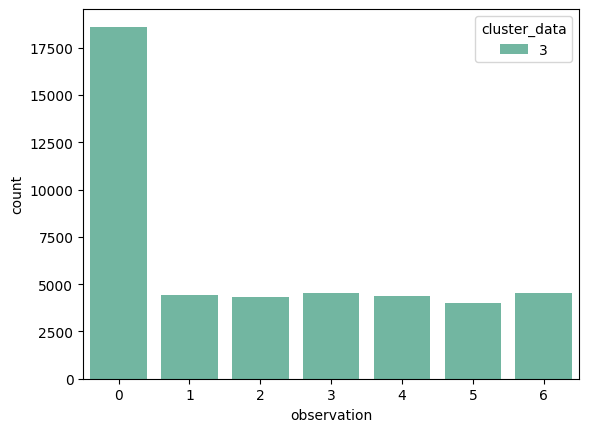

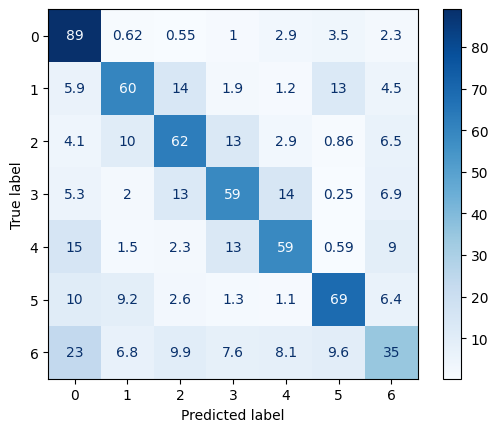

{'average_accuracy': 0.6844414695820319, 'average_f1_macro': 0.5890610018723027, 'average_f1_micro': 0.6844414695820319, 'average_auc': 0.9119278920646856, 'average_acc_kelas_generatif': 0.5622421438210913, 'average_acc_fase_padi': 0.5589301334933766}
{'val_accuracy': 0.7032350597609561, 'val_f1_macro': 0.6185532584069008, 'val_f1_micro': 0.7032350597609561, 'val_auc': 0.9257277958465506, 'val_acc_kelas_generatif': 0.5870724819579541, 'val_acc_fase_padi': 0.5997413514387326, 'val_relative_acc': 96.06433155493698}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)